In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip install --upgrade -q wandb

In [2]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.0 MB/s eta 0:00:00a 0:00:01


In [3]:
import wandb
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from scipy import stats
import seaborn as sns
import operator
from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
from textstat import flesch_reading_ease
from textblob import TextBlob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import subprocess 

nltk.download('wordnet', download_dir='/kaggle/working/')
command = "unzip /kaggle/working/corpora/wordnet -d /kaggle/working/corpora"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wb_login")

! wandb login $secret_value_0

In [ ]:
CONFIG = {'competition': 'AWMadison', '_wandb_kernel': 'avb'}

In [ ]:
run = wandb.init(project='EnglishLanguageLearner', name='CoverPhoto', config=CONFIG)
cover = plt.imread("/kaggle/input/cover-photo/john-schnobrich-2FPjlAyMQTA-unsplash.jpg")
wandb.log({"example": wandb.Image(cover)})
wandb.finish()

In [4]:
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='AWMadison', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None, kde=False):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, kde, title)})

In [5]:
train = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
train.shape

(3911, 8)

In [7]:
train.isnull().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

In [8]:
test = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [9]:
test.shape

(3, 2)

In [10]:
test.isnull().sum()

text_id      0
full_text    0
dtype: int64

# Basic Analysis

In [ ]:
run = wandb.init(project='EnglishLanguageLearner', name='explore', config=CONFIG)

In [ ]:
wandb.log({
    "train_length":train.shape[0],
    "train_cols":train.shape[1],
    "Null values":train.isnull().sum().sum()
})

In [11]:
train.select_dtypes(['int','float']).describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.000000,3.127077,0.662542,1.000000,2.500000,3.000000,3.500000,5.000000
syntax,3911.000000,3.028254,0.644399,1.000000,2.500000,3.000000,3.500000,5.000000
vocabulary,3911.000000,3.235745,0.583148,1.000000,3.000000,3.000000,3.500000,5.000000
phraseology,3911.000000,3.116850,0.655997,1.000000,2.500000,3.000000,3.500000,5.000000
grammar,3911.000000,3.032856,0.699841,1.000000,2.500000,3.000000,3.500000,5.000000
conventions,3911.000000,3.081053,0.671450,1.000000,2.500000,3.000000,3.500000,5.000000


In [ ]:
table = train.select_dtypes(['int','float']).describe().reset_index()
tbl = wandb.Table(data=table)
wandb.log({"Scores Descriptive Analysis": tbl})

* Essay Example:

In [13]:
train.full_text[0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

* Remove \n

In [14]:
train['full_text'] = train['full_text'].replace(re.compile(r'[\n\r\t]'), '', regex=True)
test['full_text'] = test['full_text'].replace(re.compile(r'[\n\r\t]'), '', regex=True)

* Another issue with the dataset is bad spacing with ',' and '.'. Using a word-tokenizer will be no issue but removing the punctuations after that will result in a large sequence of words without any spacing.

In [15]:
corpus = ''.join(train['full_text'])
data = Counter(corpus.split())
word_count = pd.DataFrame({'words':list(data.keys()), 'count':list(data.values())})
word_count['word_length'] = word_count['words'].apply(lambda x: len(x))
word_count = word_count.sort_values(by='word_length', ascending=False).reset_index()

In [16]:
word_count.head()

,index,words,count,word_length
0,52317,prompt.Generic_NameGeneric_SchoolGeneric_CityG...,1,86
1,11597,"riding,skateboarding,rollerskating,surfing,scu...",1,75
2,11643,"ride,rock-climb,roller-skating,surfing,camping...",1,66
3,49977,sucessful.Vocabulary:-Blunder-Unavoidable-Prin...,1,63
4,39511,success.Generic_Name.11/20/2019Generic_School....,1,59


In [ ]:
table = word_count.drop('index', axis=1)
tbl = wandb.Table(data=table)
wandb.log({"5 most frequent sequences": tbl})

* Although count for 'prompt.Generic_NameGeneric_SchoolGeneric_CityGeneric_CityGeneric_Name04/9/2019Teacher:' is 1, find how many times 'Generic' occurs

In [17]:
print('Number of occurences for Generic word:', word_count[word_count['words'].str.contains('Generic')]['count'].sum())

Number of occurences for Generic word: 1756


* Example text containing sequences of Generic word

In [18]:
for text in train.full_text:
    for word in text.split():
        if word == 'Generic_Name,Generic_Name,':
            print(text)
            break

"Where is one place in the world you would like to visit?""We should to go toGeneric_City over the summer, and talk to new people!" I excitedly told my friends 3 weeks before the school was gonna end. My friends, Generic_Name,Generic_Name, Generic_Name, and I think that Generic_City is the best place that we can go visit, because it can be a very exiting experience, and we can go out to see the Eiffel Tower, and experience the life of other people.First I would visit the Eiffel tower with my friends.The amazing height of the Eiffel tower. When we were walking to go see the Eiffel tower, it didn't seem big, but when we got closer, it seemed huge, I was shocked because I never knew that it was very huge. Then on the top of the Eiffel Tower, the city can be seen. As we were on the top of the Eiffel tower I could not believe that I could see the beautiful view of the lights of the city. Finally we took pictures of the the beautiful surroundings of the Tower. My friends were very happy when

In [ ]:
wandb.finish()

# Scoring Measurement Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


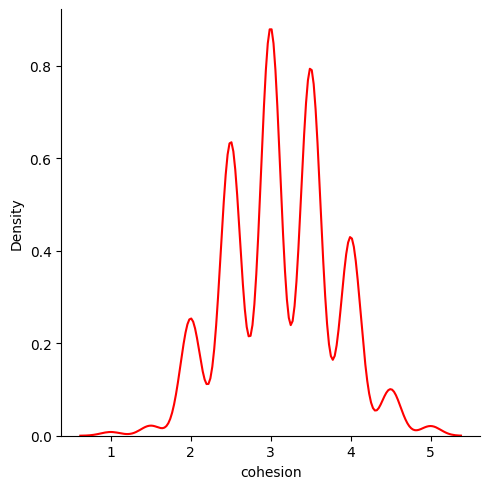

In [19]:
sns.displot(train['cohesion'], kind='kde', color = 'red')

/tmp/ipykernel_32/835338514.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col], fit=stats.norm)
/tmp/ipykernel_32/835338514.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col], fit=stats.norm)
/tmp/ipykernel_32/835338514.py:7: UserWarning: 

`distplot` is a deprecated func

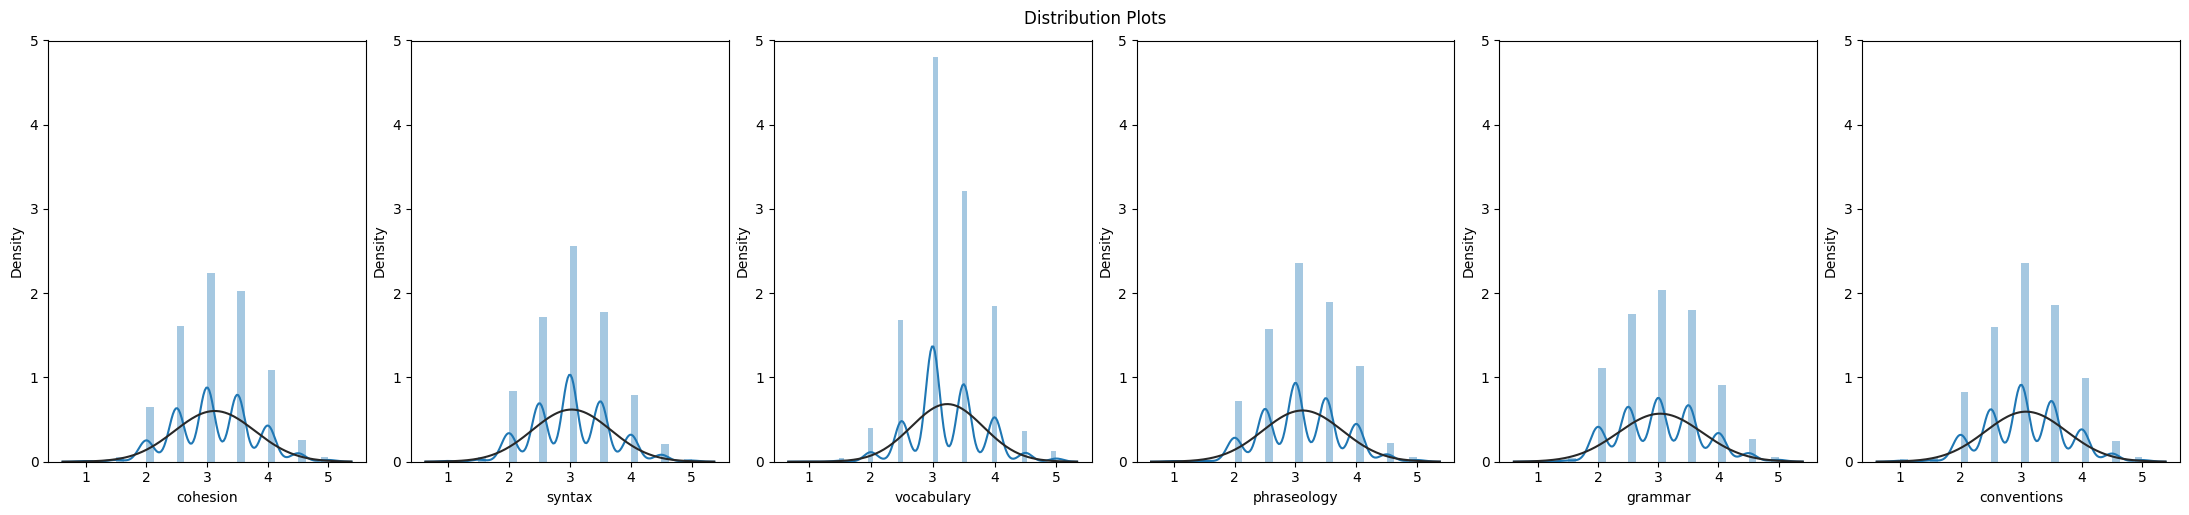

In [20]:
figure = plt.figure(figsize = (22,5))
for i, col in enumerate(train.select_dtypes(['int','float']).columns): 
    ax = plt.subplot(1, 6, i+1)
    if train[col].dtype == 'int': 
        sns.distplot(train[col], fit=stats.norm, color = 'red')        
    else: 
        sns.distplot(train[col], fit=stats.norm)        
    ax.set_ylim((0.0, 5.0))
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Distribution Plots', y=1.02)
plt.show()

Considering that getting more than 2.5 in a scoring measurement, means that it's passed. Taking this into account analysing the balance between failures and passes.

In [ ]:
#wandb.log({"Distribution Plot": figure})

* Considering 2.5 score as passing for each score category

In [21]:
conditionlist = [(train['cohesion'] >= 2.5), (train['cohesion'] < 2.5)]
choicelist = [1,0]
train['passed'] = np.select(conditionlist, choicelist, default='Not Specified')

In [22]:
train[train['passed'] == '0']['passed']

15      0
21      0
25      0
34      0
39      0
       ..
3831    0
3832    0
3880    0
3888    0
3896    0
Name: passed, Length: 352, dtype: object

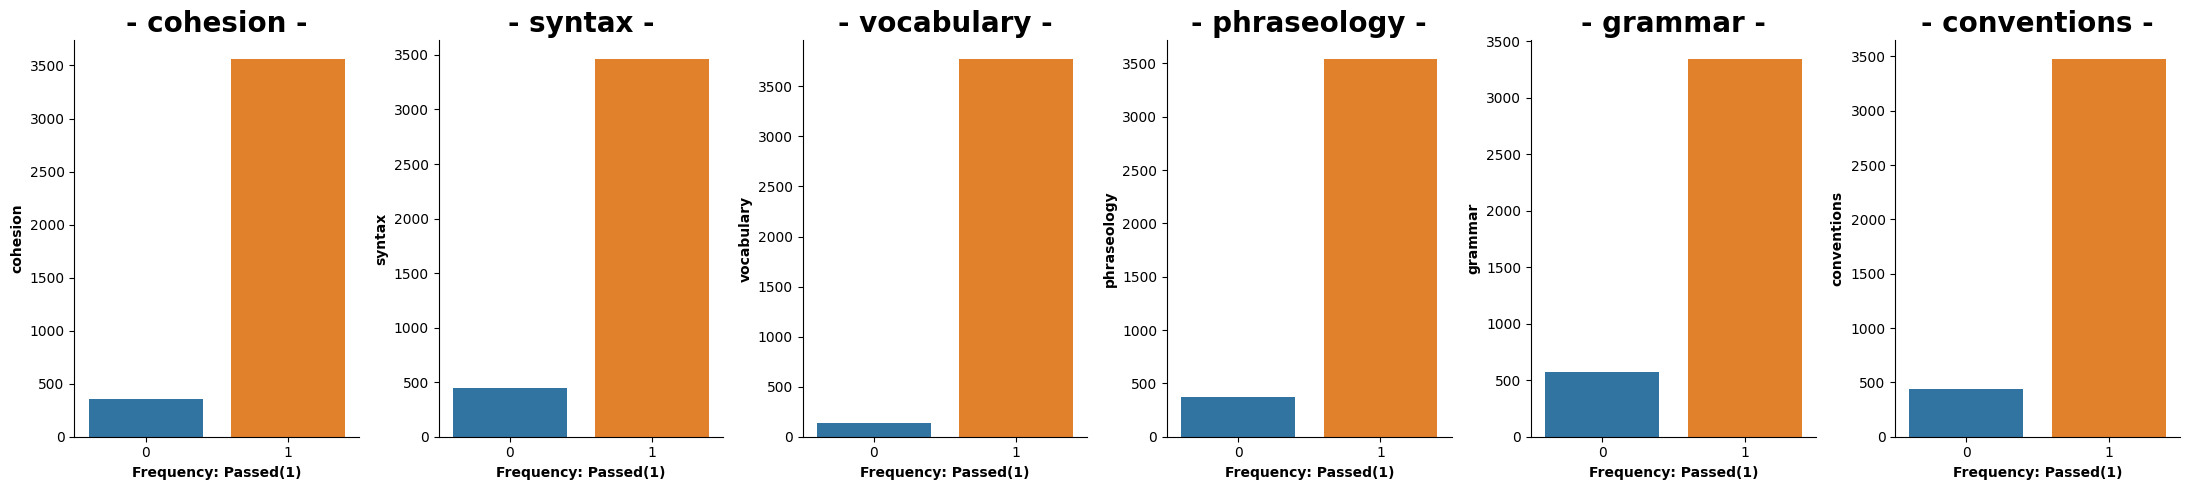

In [24]:
figure, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize = (22,5))
titles = train.select_dtypes(['float']).columns  

for ax, t in zip([ax1, ax2, ax3, ax4, ax5, ax6], titles):
    conditionlist = [(train[t] >= 2.5), (train[t] < 2.5)]
    choicelist = [1,0]
    train['passed'] = np.select(conditionlist, choicelist, default='Not Specified')
    train['passed'] = list(map(int, train['passed']))
    x_data = train['passed'].value_counts().index
    y_data = train['passed'].value_counts()
    sns.barplot(x=x_data, y=y_data, ax=ax)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_xlabel("Frequency: Passed(1)", weight="bold")
    ax.set_ylabel(f"{t}", weight="bold")
    create_wandb_plot(y_data=y_data,
                  x_data=x_data, 
                  x_name="Frequency: Passed(1)", 
                  y_name=f"{t}", 
                  title=f"{titles[0]}",
                  log="pass_score", plot="bar")
    del train['passed']
    
sns.despine()
figure.tight_layout();

There are much more passes than failures, in each of the scoring measurements.

In [26]:
#train = train.drop('passed',axis=1)

Text(0.5, 1.0, 'Total Score')

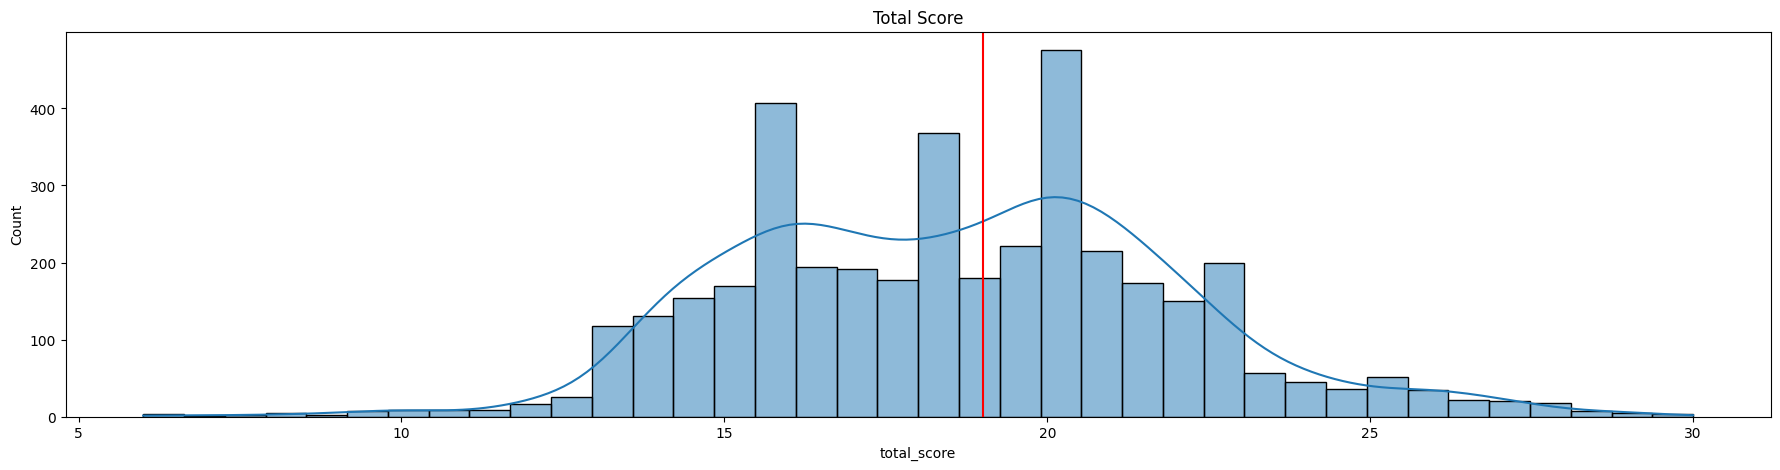

In [27]:
train['total_score'] = train['cohesion'] + train['syntax'] + train['vocabulary'] + \
                       train['phraseology'] + train['grammar'] + train['conventions']

avg_total_score = round(train['total_score'].mean())
fig  = plt.figure(figsize = (22,5))
sns.histplot(train['total_score'], kde=True)
plt.axvline(x = avg_total_score, color = 'red')
plt.title('Total Score')

* Quick example of a perfect essay (score = 30.0):

In [28]:
train[train['total_score'] == 30]['full_text'].item()

"I agree with Michelangelo's statement as I have found through experience that it benefits me more to set high expectations and not reach my goal, rather than settling on a low goal and achieving it. When setting high goals, I find that I learn more and progress my abilties further than I do with a lower goal. This is because setting high goals requires confidence, challenges, and pride.Firstly, hard work is required to achieve high goals, and requires confidence. Confidence involves having trust and believing that you are capable of accomplishing something. I have found that when I set high goals, I feel more confident in my abilities. With lower goals however, my confidence is lower as I settle for the easier path and do not trust myself to do better. With a higher aim, my confidence motivates me to not give up. I tend to try harder, and always believe in myself. For example, at school, I had to choose whether I wanted to try out for the varsity tennis team or remain in the club team

# Character Count

In [29]:
train['character_count'] = train['full_text'].str.len()
print('Average Character Count:', round(train['character_count'].mean()))
print('Max Character Count:', round(train['character_count'].max()))
print('Min Character Count:', round(train['character_count'].min()))

Average Character Count: 2325
Max Character Count: 6032
Min Character Count: 70


Text(0.5, 1.0, 'Character Count')

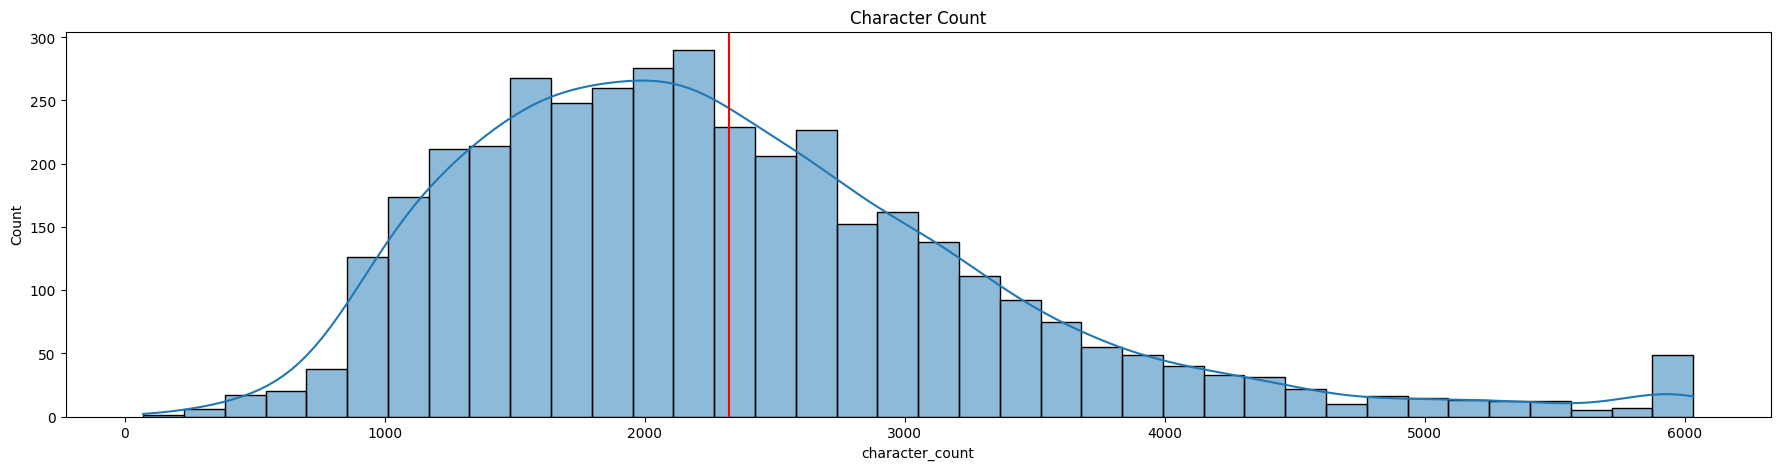

In [30]:
fig  = plt.figure(figsize = (22,5))
sns.histplot(train['character_count'], kde=True)
plt.axvline(x = round(train['character_count'].mean()), color = 'red')
plt.title('Character Count')

# Word Count

The token count will inform settings for the model, like max sequence length and the types of model architectures that can be used. Only some are suitable for very long sequences.

In [31]:
train['nwords'] = train['full_text'].apply(lambda x: len(x.split()))
avg_words = round(train['nwords'].mean())
max_words = round(train['nwords'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

Average length: 426
Max length: 1250


Text(0.5, 1.0, 'Word Count')

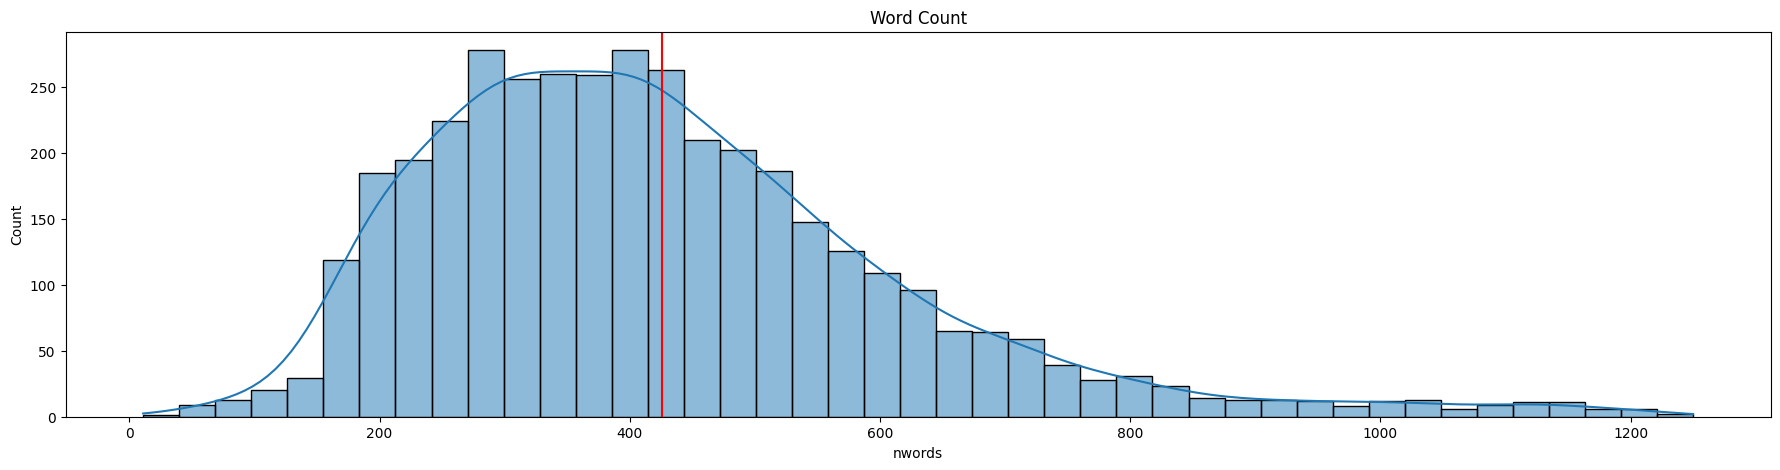

In [32]:
fig  = plt.figure(figsize = (22,5))
sns.histplot(train['nwords'], kde=True)
plt.axvline(x = avg_words, color = 'red')
plt.title('Word Count')

* Word count distribution per score

In [33]:
def plot_distribution_per_score(c): 
    scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    figure, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (22,5))
    for i, col in enumerate(scores):
        conditionlist = [
        (train[col] >= 4.5) ,
        (train[col] >= 2) & (train[col] < 4.5),
        (train[col] < 2)]
        choicelist = ['High', 'Mid', 'Low']
        train['performance'] = np.select(conditionlist, choicelist, default='Not Specified')

        mask = train.performance != 'Mid'
        sns.kdeplot(x = train[mask][c], hue = train.performance, ax = axes[i])
        axes[i].set_title(col)

        mask_low = train.performance == 'Low'
        avg_low = train[mask_low][c].mean()
        axes[i].axvline(x = avg_low, color = 'green', linestyle = '--')

        mask_high = train.performance == 'High'
        avg_high = train[mask_high][c].mean()
        axes[i].axvline(x = avg_high, color = 'orange', linestyle = '--')

        del train['performance']

In [ ]:
# understand the chart below

Word count tend to be greater for essays having high scores. Except for grammar, where both means are almost equal

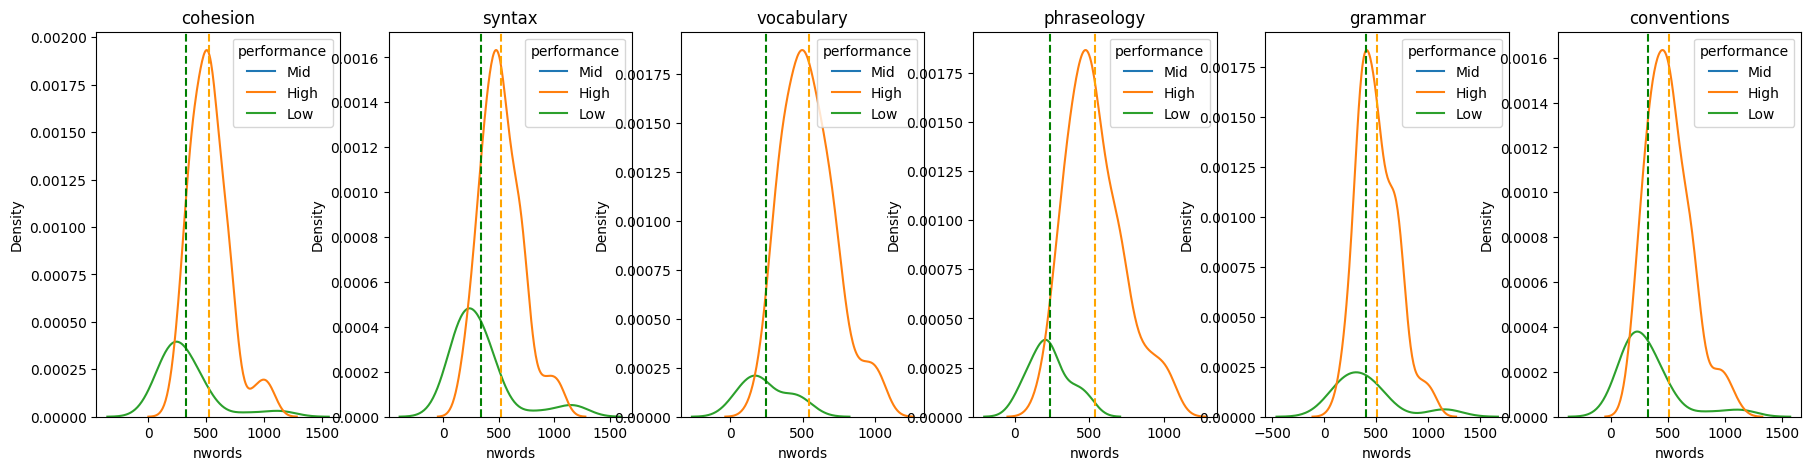

In [34]:
plot_distribution_per_score('nwords')

# Sentence Count and Average Length

In [35]:
train['sentence_count'] = train['full_text'].apply(lambda x: len(sent_tokenize(x)))
print('Average number of sentences in a text:', round(train['sentence_count'].mean()))

train['avg_sentence_length'] = train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
print('Average sentence length:', round(np.mean(train['avg_sentence_length'])))

Average number of sentences in a text: 14
Average sentence length: 54


Text(0.5, 1.0, 'number of sentences')

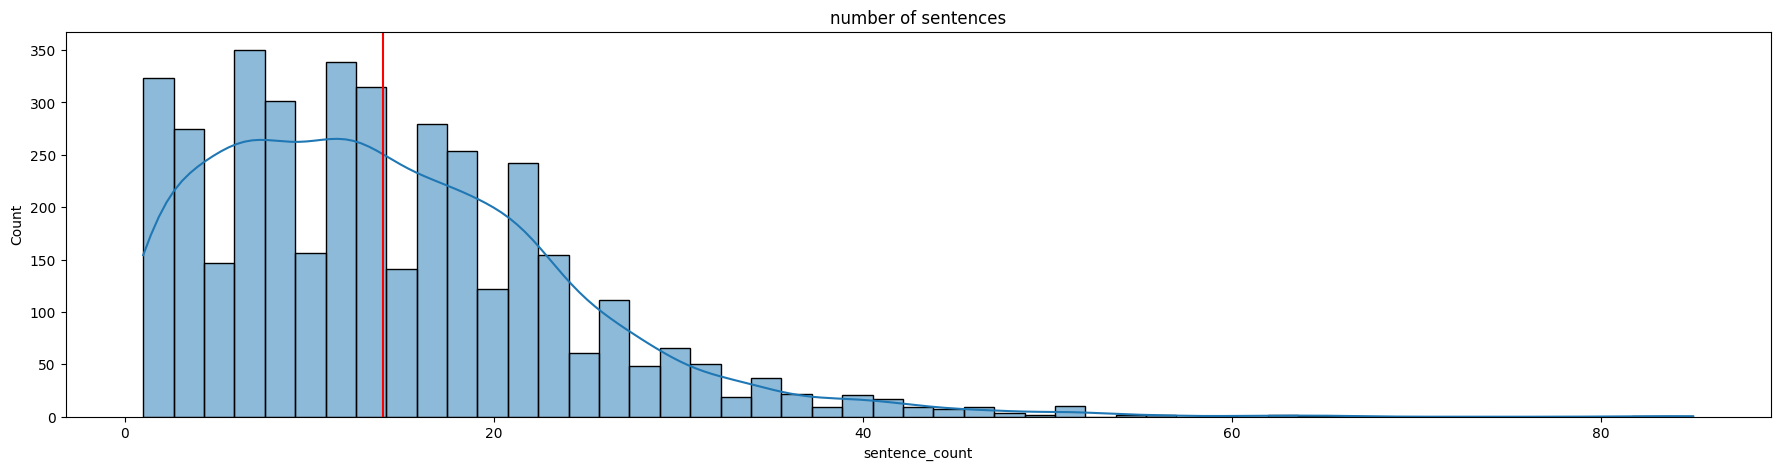

In [36]:
fig  = plt.figure(figsize = (22,5))
sns.histplot(train['sentence_count'], kde=True)
plt.axvline(x = round(train['sentence_count'].mean()), color = 'red')
plt.title('number of sentences')

Text(0.5, 1.0, 'Sentence length')

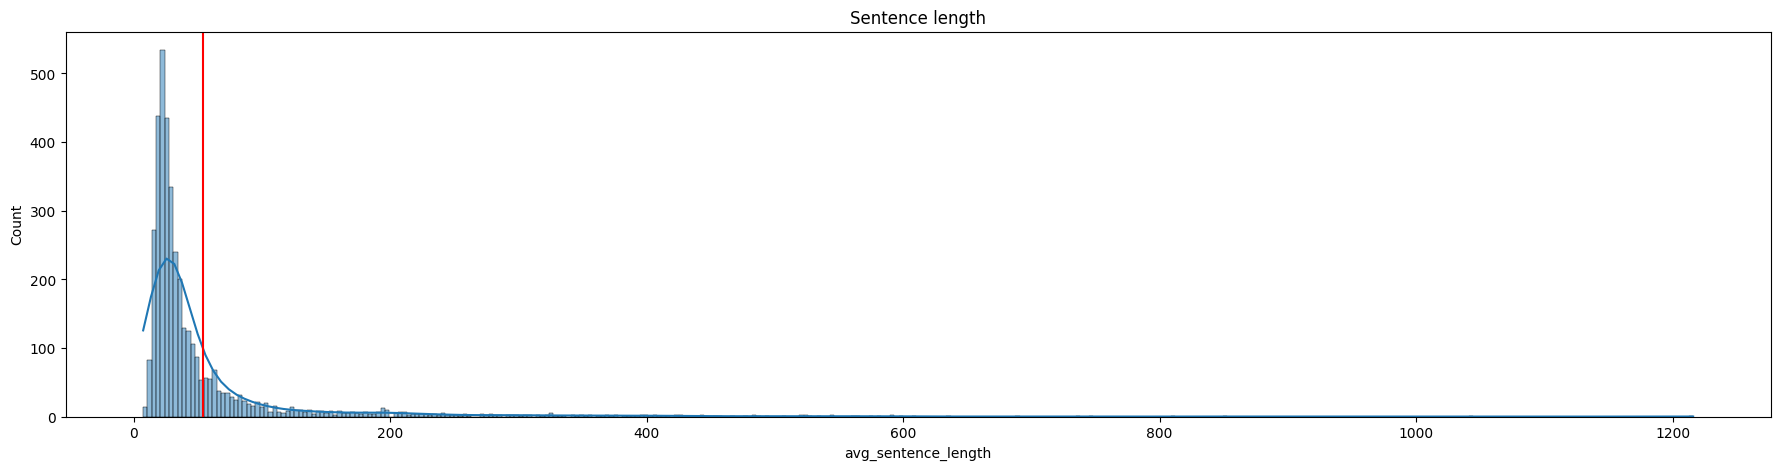

In [37]:
fig  = plt.figure(figsize = (22,5))
sns.histplot(train['avg_sentence_length'], kde=True)
plt.axvline(x = round(train['avg_sentence_length'].mean()), color = 'red')
plt.title('Sentence length')

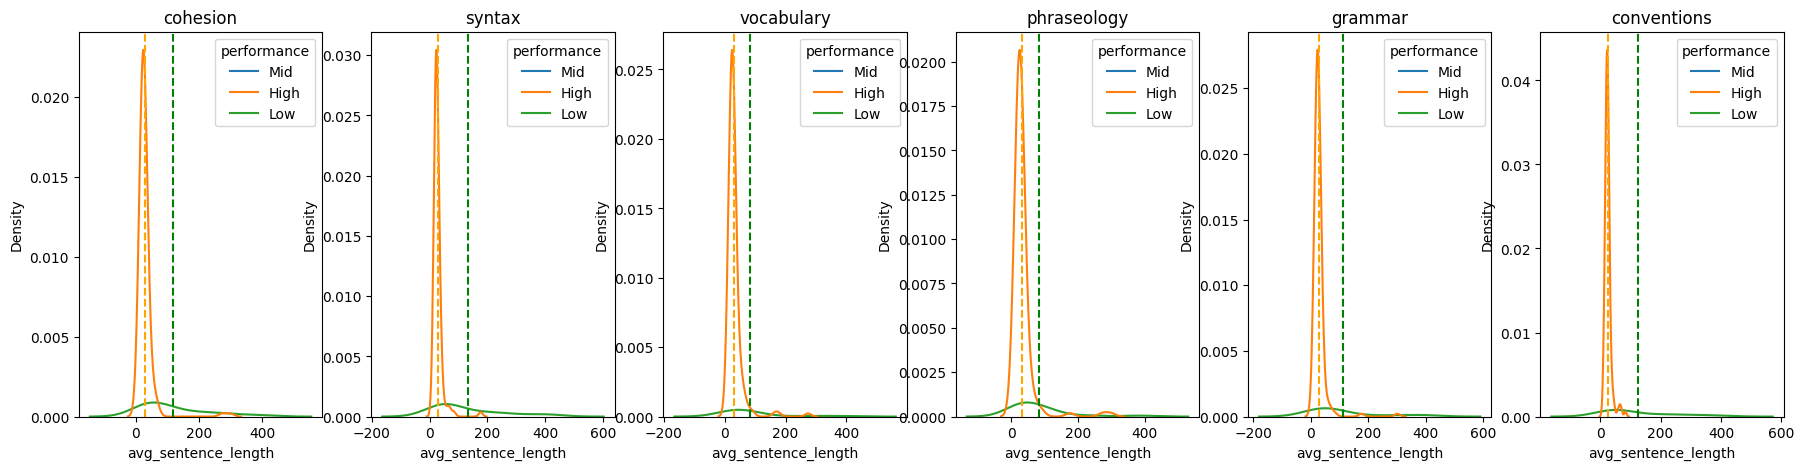

In [39]:
plot_distribution_per_score('avg_sentence_length')

* Small sentence length -> high scores

# Stop words

In [40]:
eng_stopwords = set(stopwords.words('english'))
print(eng_stopwords)

{'who', 'or', 'here', 'won', 'wouldn', 'ma', 's', "isn't", 'between', 'any', "doesn't", 'me', 'mustn', 'my', "you're", "shan't", 'above', "she's", "needn't", 'our', 'theirs', 'your', 'a', "it's", 'only', 'has', 'before', 'shouldn', 'you', 'ain', 'yourself', 'against', 'now', 'don', 'nor', 'until', 'there', 'too', 'he', 'through', 'some', 'from', 'll', 'then', 'had', 'their', "don't", "you'll", "won't", 'as', 'more', 'into', 'such', 'very', 've', 'm', 'up', 'yours', 'whom', 'further', 'can', 'herself', 'out', "mustn't", 'in', 'hadn', 'doesn', 'few', "shouldn't", 'again', 'off', 'after', 'couldn', 'them', 'it', 'they', "couldn't", 'i', 'when', "didn't", 'these', 'mightn', 'should', 'of', 'but', 'so', 'didn', 'o', 'no', "weren't", 'over', 'themselves', 'about', "mightn't", 'her', 'how', 'why', 'will', "you've", 'where', 'other', 'an', 'most', 'weren', 'both', 'does', 'have', 'been', 'his', 'not', 'which', 'y', "aren't", "haven't", 'during', 'below', 'him', 'needn', 'at', 't', 'am', 'hasn'

<BarContainer object of 10 artists>

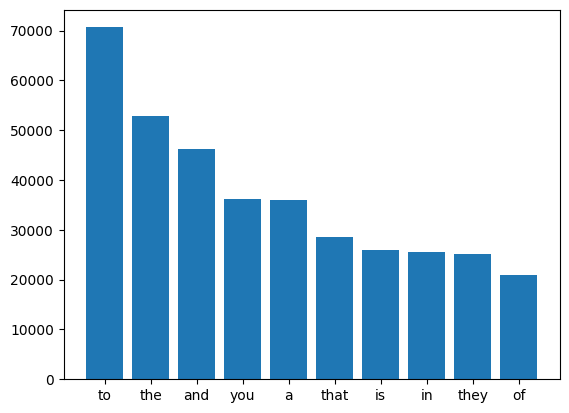

In [41]:
text_corpus = ''.join(train.full_text).split()
dict = defaultdict(int)

for w in text_corpus:
    if w in eng_stopwords:
        dict[w] += 1
        
dict_sorted = sorted(dict.items(), key = operator.itemgetter(1), reverse = True)
x, y = zip(*dict_sorted[:10])
plt.bar(x,y)

* Clean data: remove stopwords, punctuation, convert to lowercase

In [42]:
def clean_text(text):
    # lower case
    text = text.lower()
    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove non roman
    text = re.sub("([^\x00-\x7F])+", " ", text)  
    return text

In [43]:
train_df = train.copy()
train_df['full_text'] = train_df['full_text'].map(lambda x: clean_text(x))

# Most Frequent N-grams

To get the most frequent words, I made use of “corpus”. Created a list containing all relevant words from the cleaned review texts. By “relevant” word, I mean words that aren’t stopwords.

In [44]:
def most_freq_ngrams(s1=2, s2=2):
    vec = CountVectorizer(stop_words = list(eng_stopwords), ngram_range = (s1,s2))
    ngrams = vec.fit_transform(train_df['full_text'])
    
    count_values = ngrams.toarray().sum(axis=0)

    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    
    return ngram_freq

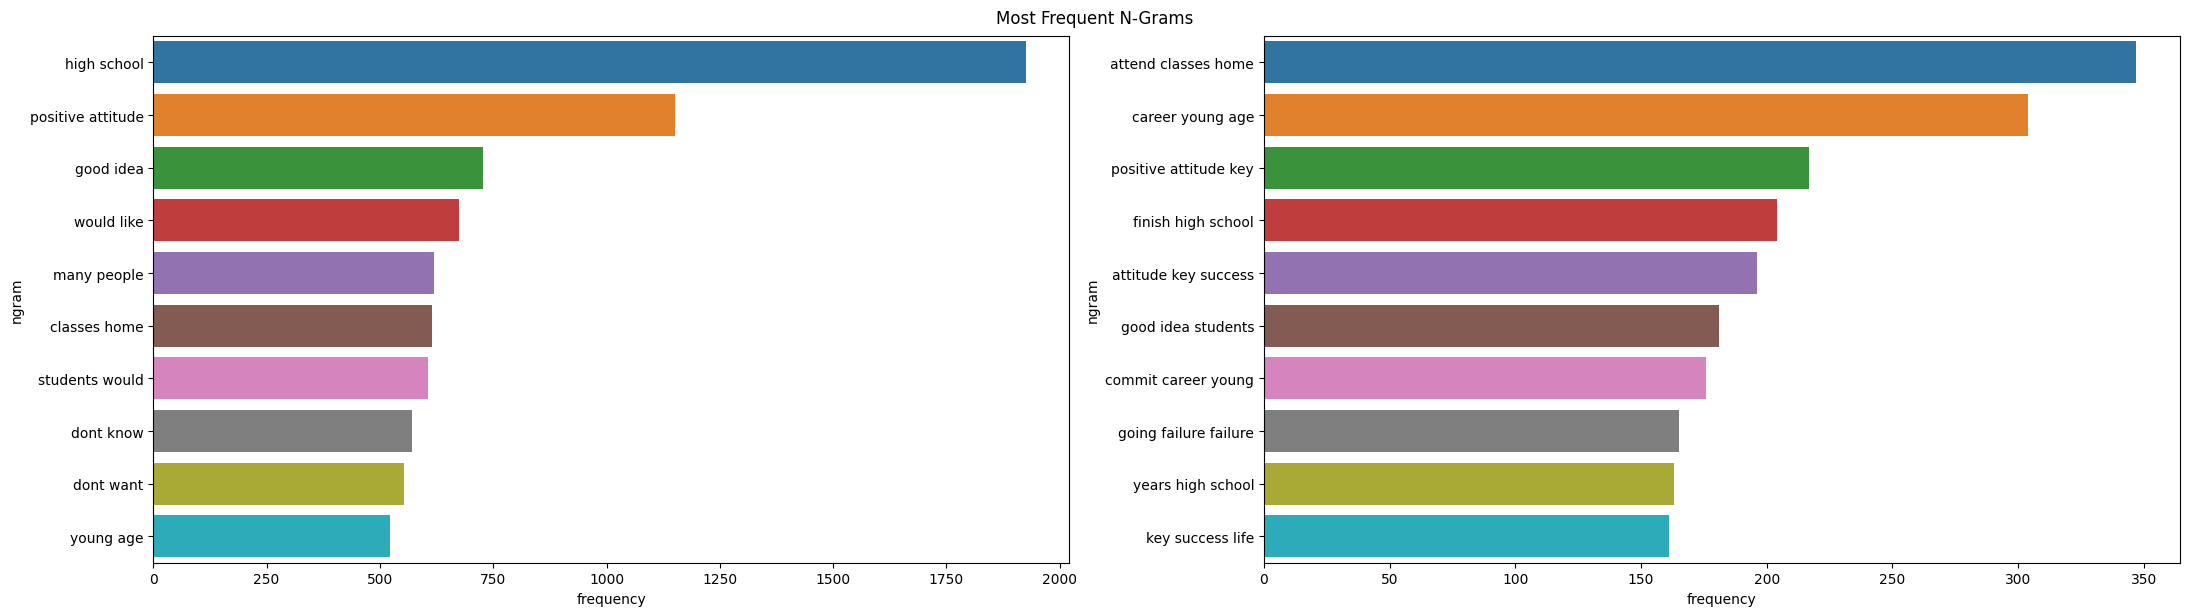

In [45]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22, 6))
for i in range(2,4):
    ngram_freq = most_freq_ngrams(i, i)
    sns.barplot(data = ngram_freq[:10], x = 'frequency', y = 'ngram', ax = axes[i-2])
    del ngram_freq
    
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Most Frequent N-Grams', y=1.02)
plt.show()

# Part of Speech Tagging

POS tagging takes every token in a text and categorizes it as nouns, verbs, adjectives, and so on, as shown below:

In [46]:
def get_token(tags, tag_type):
    tokens = [word for word, pos in tags if ((pos == tag_type) & (word not in eng_stopwords))]
    return tokens 

def show_most_common(tags, tag_type, row=-1, col=-1):
    pos_tags = get_token(tags, tag_type)
    most_common = Counter(pos_tags).most_common(10)
    
    # Visualize most common tags as bar plots
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)
    
    pos_freq = pd.DataFrame({'words':words, 'frequency':frequency})

    if col == -1: sns.barplot(data = pos_freq, x = 'frequency', y = 'words')
    else: sns.barplot(data = pos_freq, x = 'frequency', y = 'words', ax = axes[row][col])

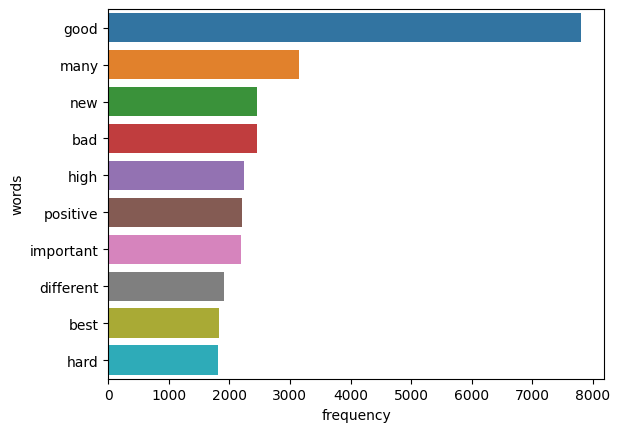

In [47]:
corpus_wo_stopwords = [w for w in text_corpus if w not in eng_stopwords]
tags = nltk.pos_tag(corpus_wo_stopwords, tagset = 'universal')

show_most_common(tags, 'ADJ')

* Most common tokens for different scores. The aim of this is to analyse which type of words appear more in low and high graded essays.

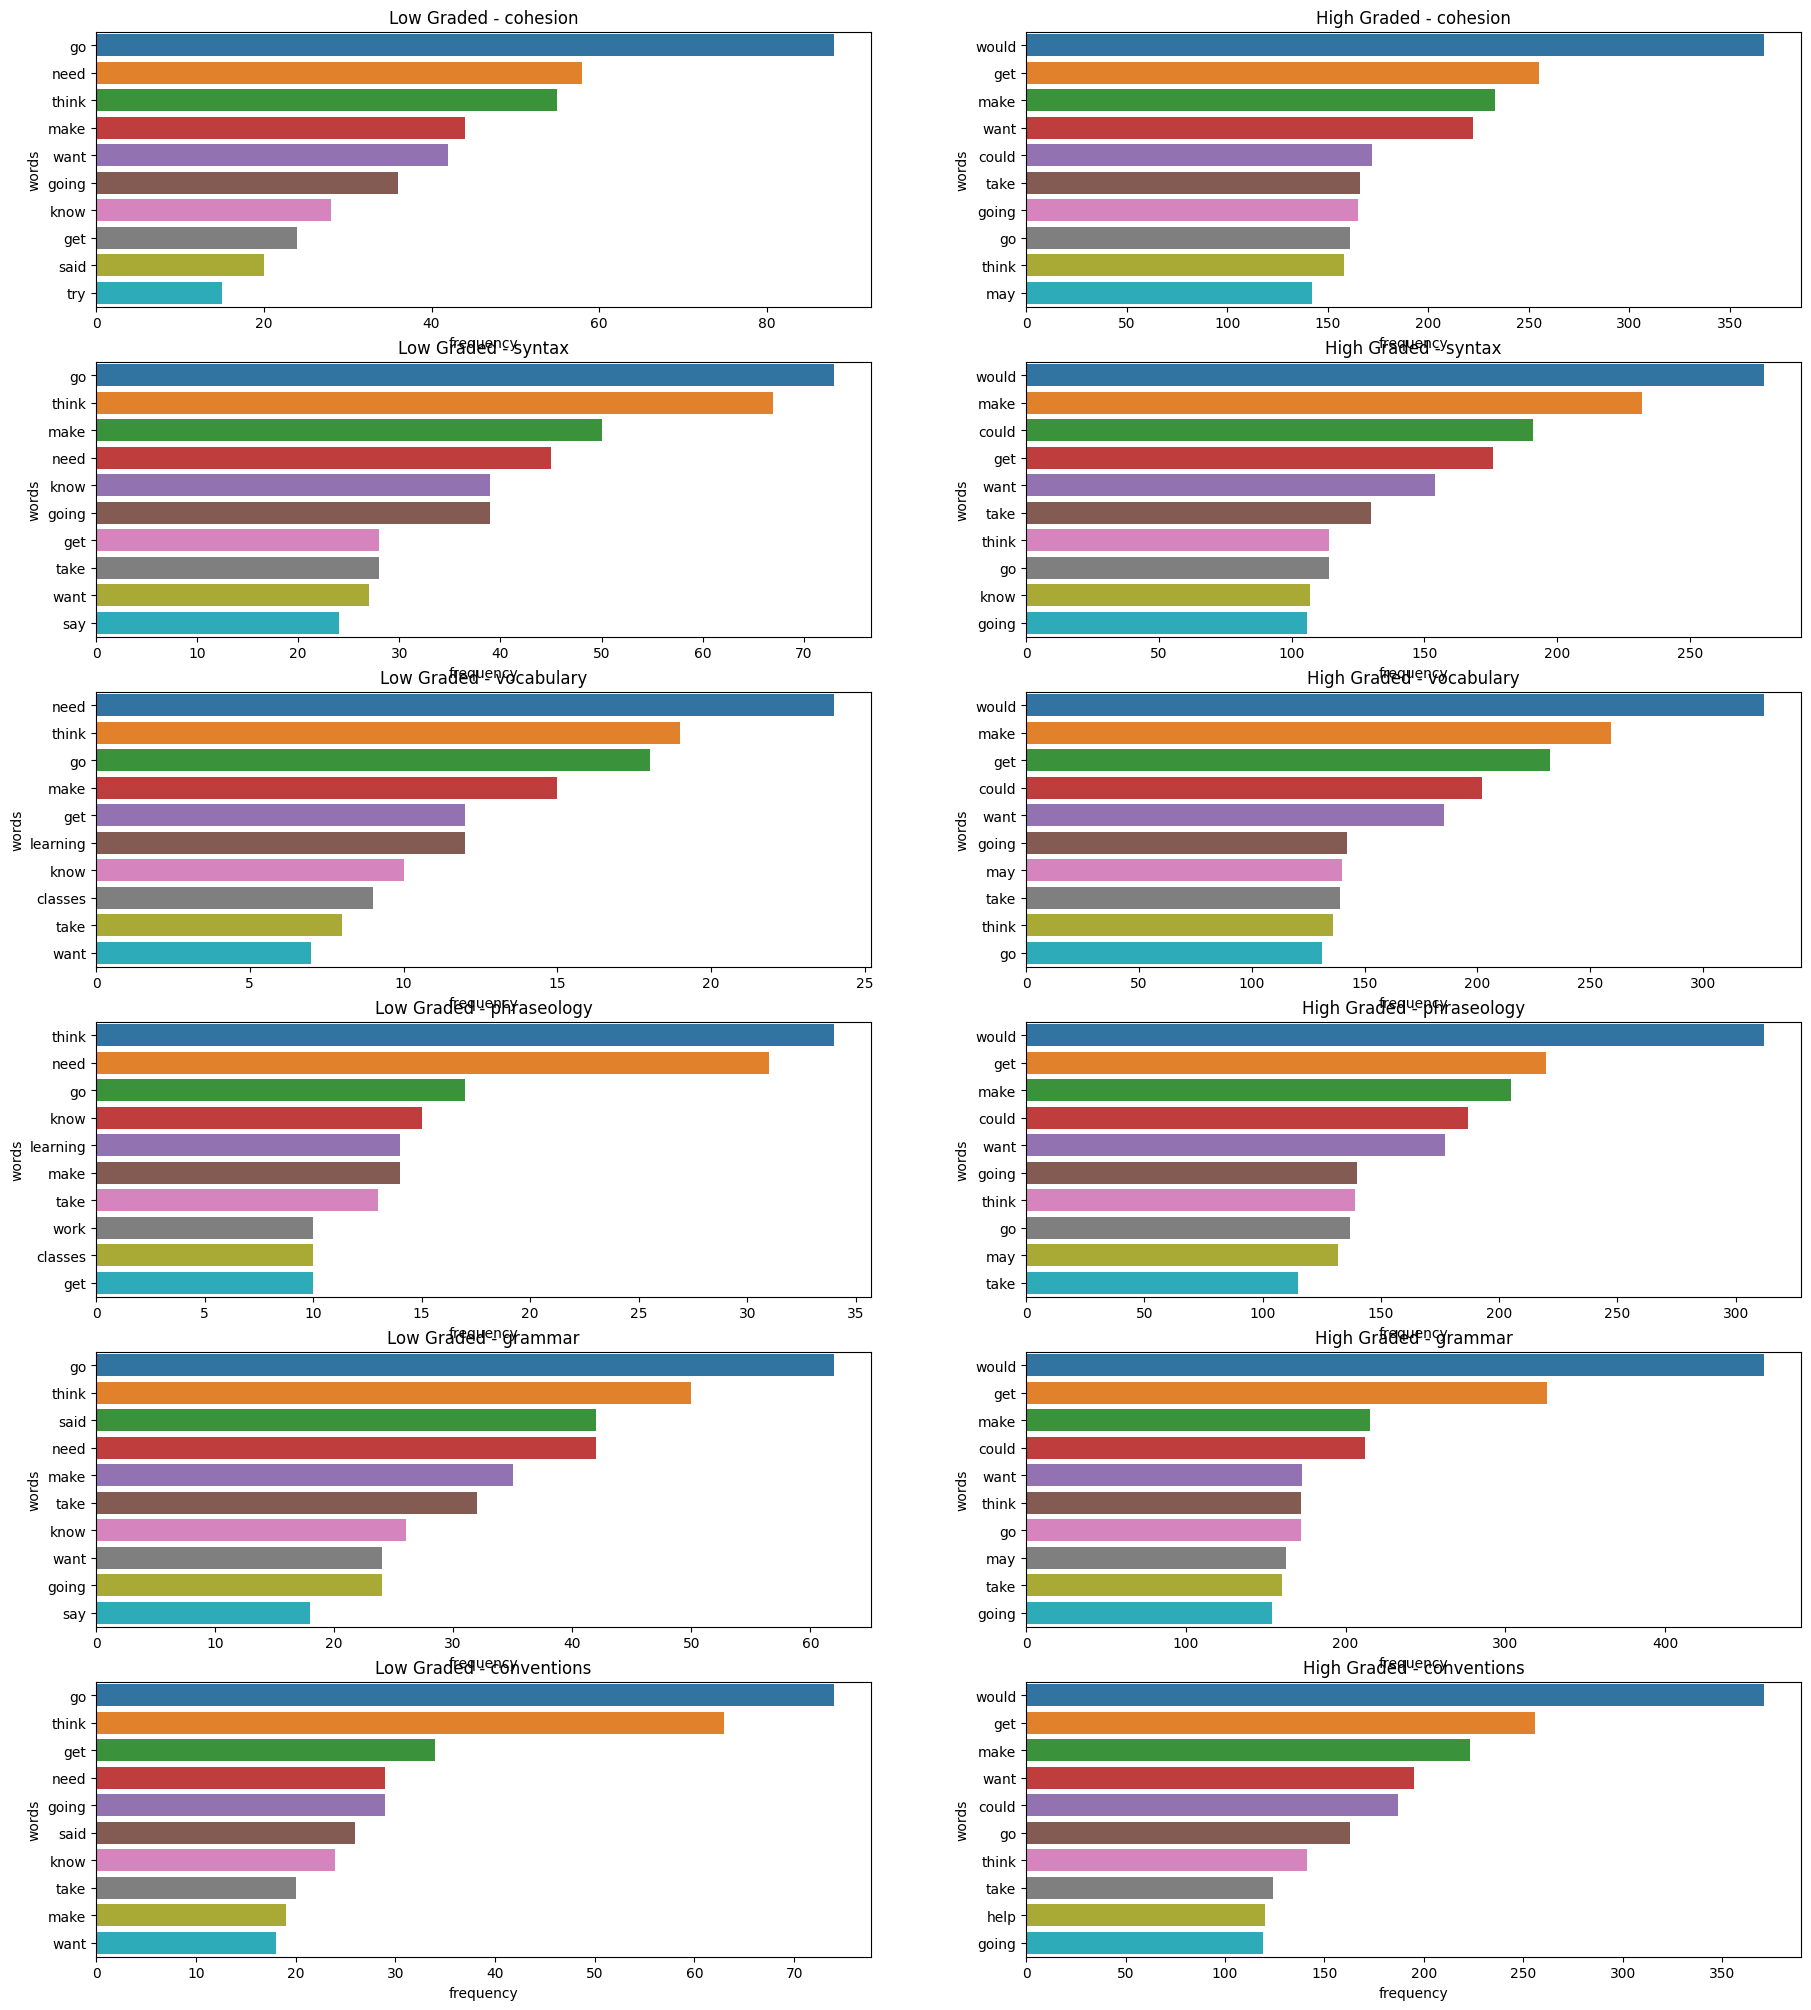

In [48]:
scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
figure, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (22,25))

for i, col in enumerate(scores):
    for j in range(2):
        
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train[col] < 2 if j == 0 else train[col] > 4
        
        corpus = ''.join(train[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")
        show_most_common(tags, 'VERB', i, j)
        axes[i,j].set_title(title)

**VERB**:
* Auxiliary verb **would** leads every plot in high grade essays.
* The same happens in low graded plot, but with verb **go**.
* Main difference between low and high graded essays' verbs:
* * In high graded ones, there are auxiliary verbs like **would, could, may**, etc

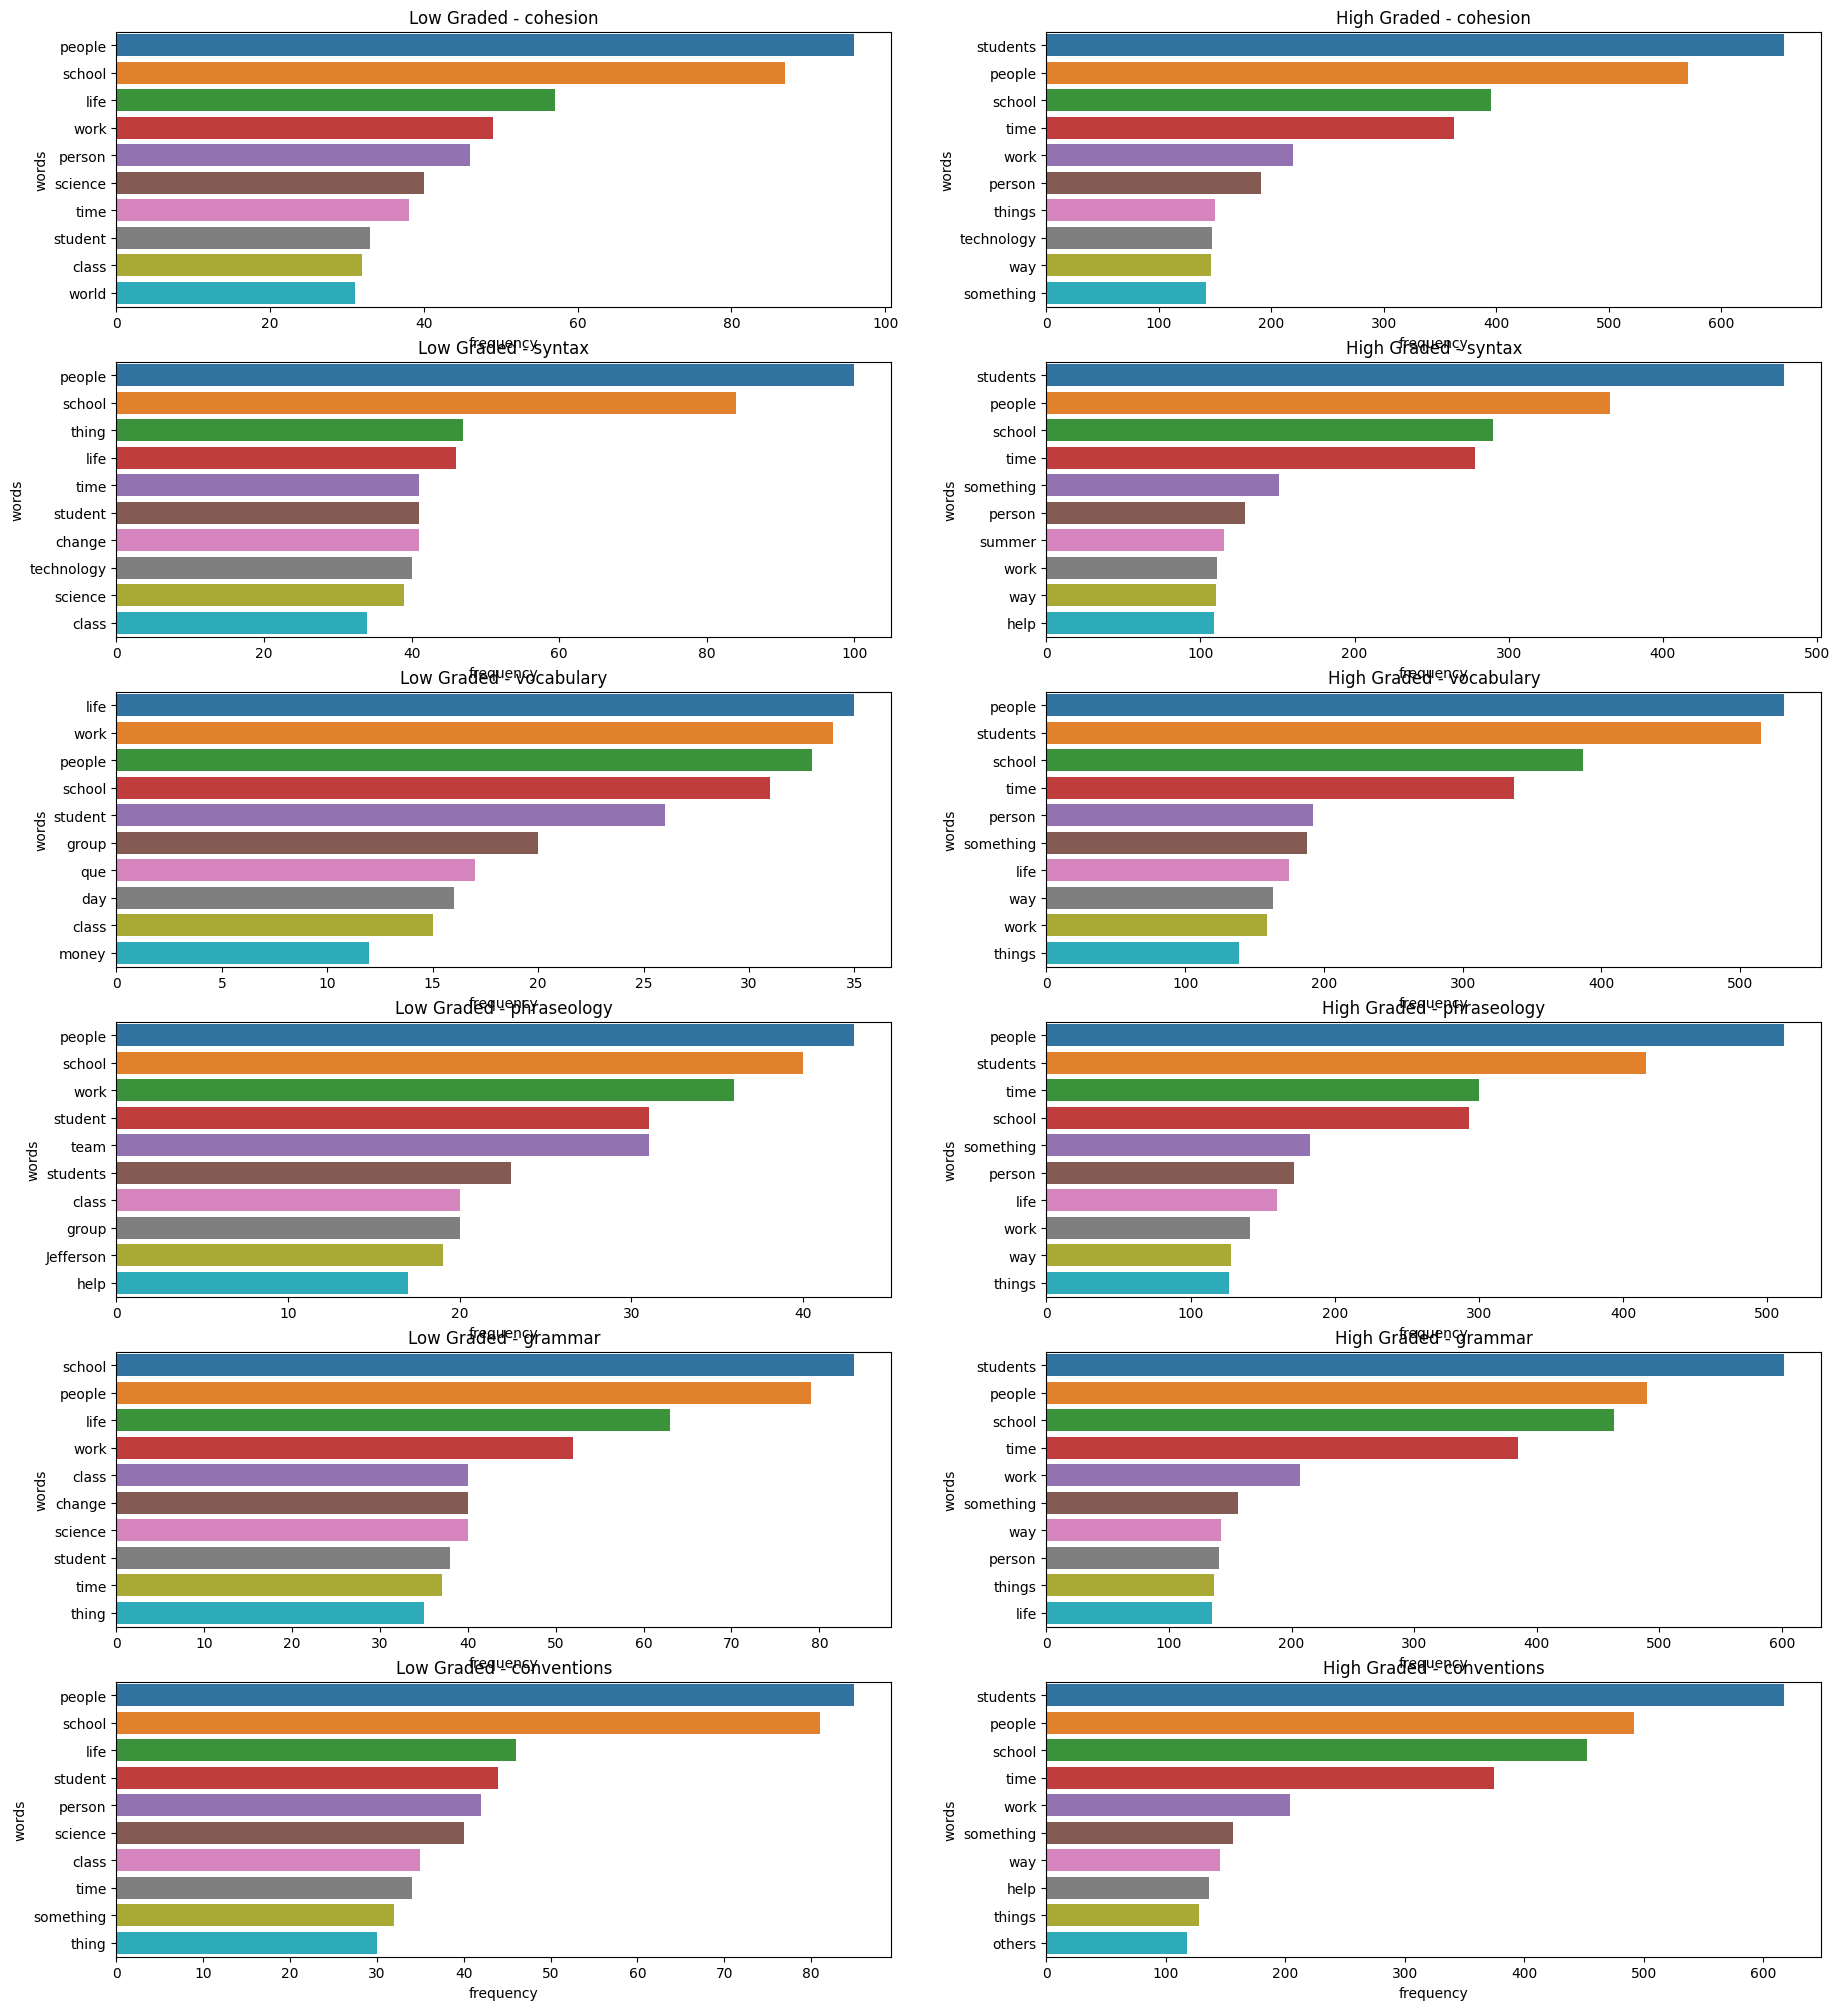

In [49]:
scores = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
figure, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (22,25))

for i, col in enumerate(scores):
    for j in range(2):
        
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train[col] < 2 if j == 0 else train[col] > 4
        
        corpus = ''.join(train[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        tags = nltk.pos_tag(corpus_without_stop, tagset = "universal")
        show_most_common(tags, 'NOUN', i, j)
        axes[i,j].set_title(title)

**Correlation**

* High correlation between scoring measurements suggests that essays tend to have similar grades in each of the measurements.

* Avg_sent_len is negatively correlated with every scoring measure. Thus, it can be concluded that very long phrases could have a negative impact on how an essay is graded. This make sense with observe sent_count as well. The shorter the phrases are, the more amount of phrases an essay has which is the reason for its positive correlation with the scoring measurements.

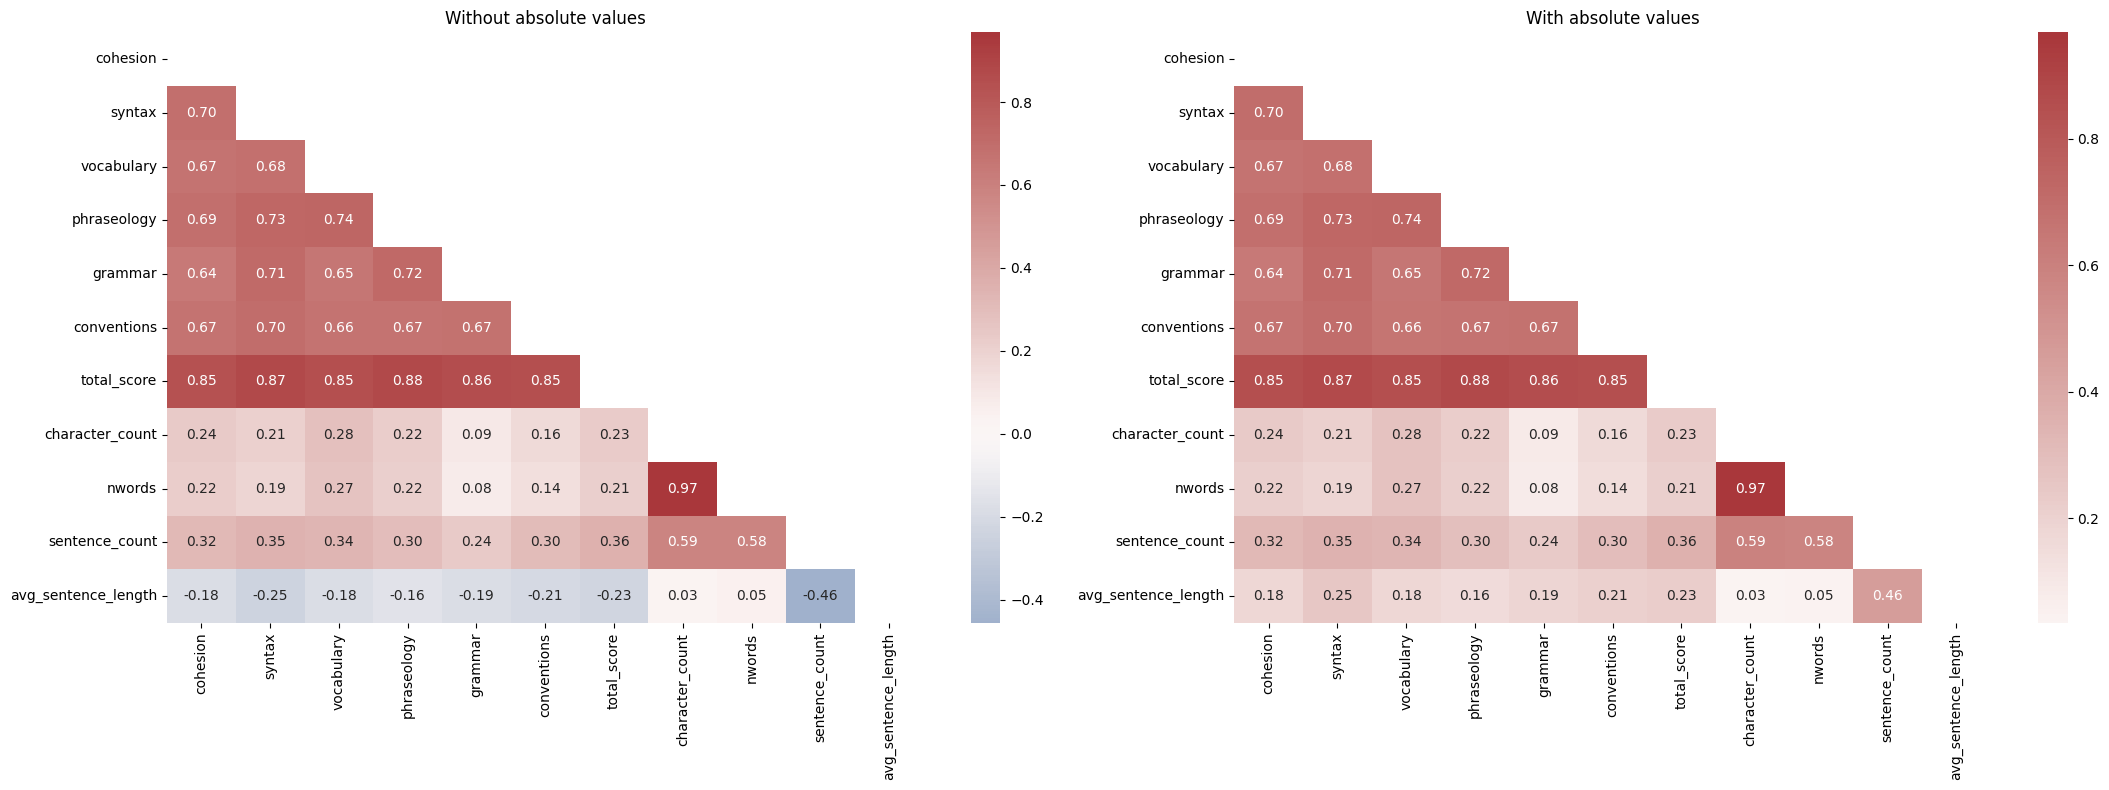

In [50]:
corr= train.select_dtypes(['int','float']).corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (22,8))
# Heatmap without absolute values
sns.heatmap(corr, mask=matrix, center = 0, cmap = 'vlag', ax = axes[0], 
            annot=True, fmt='.2f').set_title('Without absolute values')
# Heatmap with absolute values
sns.heatmap(abs(corr), mask=matrix, center = 0, cmap = 'vlag', ax = axes[1], 
           annot=True, fmt='.2f').set_title('With absolute values')

fig.tight_layout(h_pad=1.0, w_pad=0.5)

# Lemmatization

The process of converting a word to its base form.

In [51]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
print("rocks :", lemmatizer.lemmatize("rocks")) 
# print("corpora :", lemmatizer.lemmatize("corpora"))

rocks : rock


* Comparing most common lemmas in essays with a 5.0 score and low score of <=2.0

In [52]:
def most_common_lemmas(corpus):
    dict = defaultdict(int)
    for w in corpus:
        lemma = lemmatizer.lemmatize(w)
        dict[lemma] +=1
    
    dict_sorted = sorted(dict.items(), key = operator.itemgetter(1), reverse = True)
    return dict_sorted
        

* Most common lemmas are shared between both types of essays.
* However, from top 4/5 onwards the difference in technical lemmas start to be significant

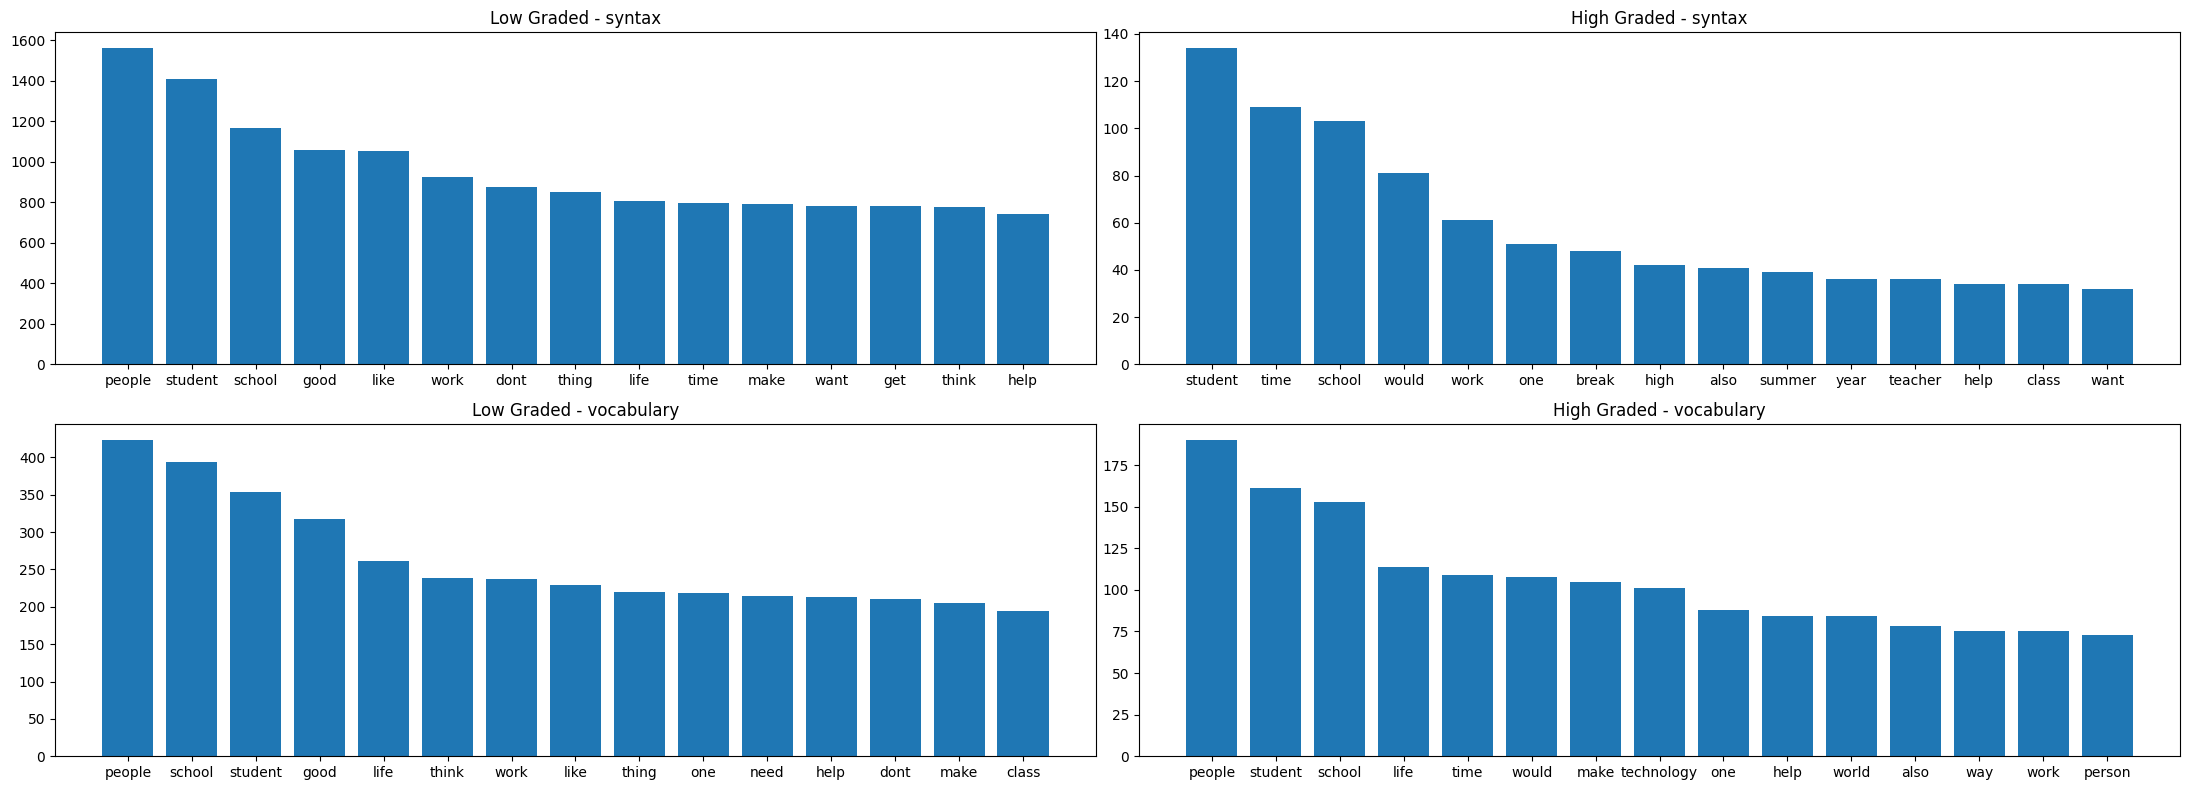

In [53]:
figure, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (22,8))
for i, col in enumerate(['syntax','vocabulary']):    
    for j in range(2):
        t = 'Low' if j == 0 else 'High'
        title = '{} Graded - {}'.format(t, col)
        mask = train_df[col] <= 2 if j == 0 else train_df[col] == 5

        corpus = ''.join(train_df[mask].full_text).split()
        corpus_without_stop = [w for w in corpus if w not in eng_stopwords]
        dic_sorted = most_common_lemmas(corpus_without_stop)
        x, y = zip(*dic_sorted[:15])
        axes[i, j].bar(x,y)
        axes[i, j].set_title(title)

figure.tight_layout(h_pad=1.0, w_pad=0.5)

# Text Complexity. Flesch Reading Ease(FRE)

Higher scores indicate material that is easier to read, lower scores mark harder-to-read passages:

Text(0.5, 1.0, 'Text Complexity')

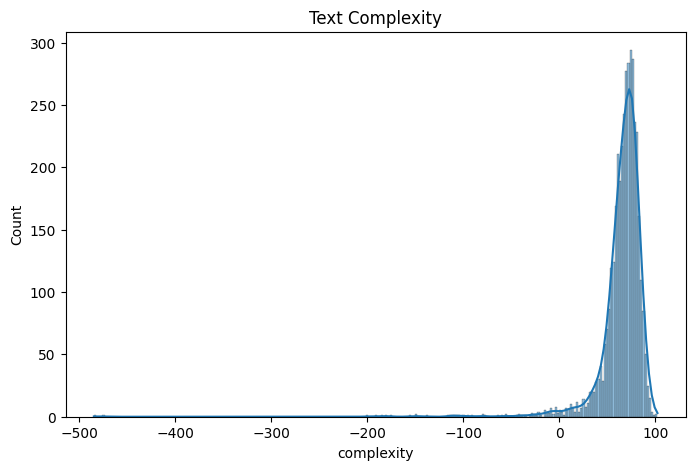

In [54]:
train['complexity'] = train['full_text'].apply(lambda x: flesch_reading_ease(x))
plt.figure(figsize = (8,5))
sns.histplot(train['complexity'], kde=True)
plt.title('Text Complexity')

* Most essays are given a score between 0 to 100 but some are given very low scores of [-100, -500)

* High Complexity score essay

In [55]:
max_complex = train['complexity'].max()

In [56]:
max_complex

102.1

* Max complexity is 102.1 and the essay scoring this high complexity should be very easy to read(for kids).

In [57]:
train[train['complexity'] == max_complex]['full_text'].item()

'Would you like to have more time at school? I would like to have more time at school. Setting at class and learning more things. Getting work done and relaxing. I have three reason why we should have more time at school.My first reason why we should have more time at5 school is getting work done. If theres more time at school,then theres more time to do your homework at school. Getting your homework done so you dont have to do ot at home because you finish your work at school. My reason is getting work done.My second reason why we should have more time at school is your friends. School can get boring so thats why you have friends so you can hangout with them at school. Your friends can be your work buddy so you and your friends can work together at school so you can finish your work. You can have fun with your friends at school so it wont be so boring i school. My other reason is your friends.My third reason why we should have more time at school is your grades. Is your grades bad? We

* Low complexity -> harder to read

In [58]:
train[(train['complexity'] > 5.0) & (train['complexity'] < 15.0)].index

Index([ 114,  633,  823,  854,  934,  991, 1165, 1234, 1302, 1517, 1524, 1548,
       1629, 1696, 1857, 2072, 2132, 2172, 2438, 2655, 2680, 2742, 3039, 3129,
       3251, 3305, 3450, 3486, 3664, 3806, 3893],
      dtype='int64')

In [59]:
train.iloc[144,:]['full_text']

"yes is good idea, because they know what they want in the future.And they can choose good career for they life. And they can preparation they can go to wall University. When they will be adult they have experience when they get job and they get own money they will be ready but you can help you family and if you have girlfriend you can help to became they help you to when you was little boy your parents away they told you what do you need to do at you life they was good example, for you no said no because you no thatIn some societies ,students can brace for the future when they want a family they are ready for change and they can get Bette life. and you can start the future they can choose some work because if you study you can get more opportunity and you can will be good person en your life a person ready for start some wort nobody said nothing because you are ready for the job and you can will be a boss in you work but, you need to study and focus in you career because you need good

* Very poor score

In [60]:
min_complex = train['complexity'].min()

In [61]:
train[train['complexity'] == min_complex]['full_text'].item()

"Being yourself doesn't depends in how people see you, it depends on you because you are the only one that can choose to change or not, it makes no difference if you did something right or wrong the society always will discriminate and see that at the way they think it is,and you can't do anything about it, you are doing the things that you feel that are correct and how is the way how is has to be, however being in a world that is trying to make you something else is a great accomplishment because there is not way people make you change;you had to live your life at the way you want it, you have the opportunity to express your feelings everywhere, and you are in the world to be happy and not to satisfy every single personSometimes it's hard for you to be deal in the society with opinions that hurt you and make you feel bad about it, and that is something that you cannot change, but it is something that help you to learn how to be more responsible when you are growing up and to be overco

Low graded essays:
* very long sentences
* wrong use of punctuations
* no full stops

# Sentiment Analysis

Text(0.5, 1.0, 'Subjetivity Distribution')

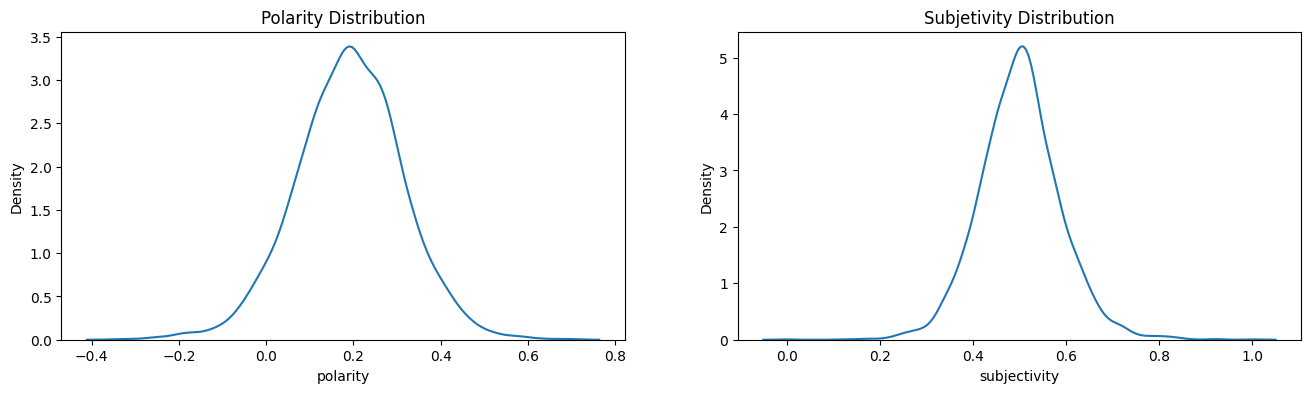

In [62]:
train['polarity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[0])
train['subjectivity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[1])

figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
sns.kdeplot(train['polarity'], ax = axes[0])
axes[0].set_title('Polarity Distribution')
sns.kdeplot(train['subjectivity'], ax = axes[1])
axes[1].set_title('Subjetivity Distribution')

# Modeling

I mainly use Deberta Transformer Model. The working procedure:

* the input sentence or text is fed into a transformer network (like Bert, Deberta, etc).
* The transformer produces contextualized word embeddings for all input tokens in our text.

As a fixed-sized output representation is required, a pooling layer is added.

In [ ]:
#train.head()

In [ ]:
run = wandb.init(project='EnglishLanguageLearner', name='modeling', config=CONFIG)

In [ ]:
#from transformers import DebertaTokenizer, TFDebertaModel
#
#tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
#tokenizer.save_pretrained("./tokenizer")
#model_deberta = TFDebertaModel.from_pretrained("microsoft/deberta-base")

In [ ]:
#del model_deberta

In [ ]:
#sequence = "A Titan RTX has 24GB of VRAM"
#tokenized_sequence = tokenizer.tokenize(sequence)
#print(tokenized_sequence)

#del sequence, tokenized_sequence
# gc.collect()

In [ ]:
#def generate_data(text, tokenizer):
#    encoded = tokenizer.batch_encode_plus(text, truncation = True, padding = "max_length", max_length = 128, 
#                                          add_special_tokens = True, return_attention_mask = True)
#    input_ids = np.array(encoded["input_ids"], dtype = "int32")
#    attention_mask = np.array(encoded["attention_mask"], dtype = "int32")
#    
#    return {"input_ids":input_ids, "attention_mask":attention_mask}

#model_input = generate_data(train["full_text"], tokenizer)
#test_encoded = generate_data(test["full_text"], tokenizer)

**Model Architecture (No finetuning)**

I am extracting embedding from non-finetuned Transformers (Deberta base, Deberta Large, Funnel Transformer, Bigbird, etc). With this, a huge amount of time will be saved. Lastly, a multioutput regressor is added as the head of the model, and feed it with an ensembling of all the embeddings extracted before.

In [5]:
from IPython.display import clear_output, display_html
import gc; gc.enable()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
import warnings
from pathlib import Path

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats

# Train Test Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Optuna - Bayesian Optimization 
import optuna
from optuna.samplers import TPESampler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# PyTorch
import torch
import torch.nn as nn

# Transformers
import transformers
from transformers import AutoModel, AutoConfig, AutoTokenizer

# Regressors
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tqdm import tqdm

warnings.filterwarnings('ignore')
MAX_SEQ_LEN = 256

def load_data():
    '''Load each of the datasets we are given.'''
    
    data_dir = Path("/kaggle/input/feedback-prize-english-language-learning")
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')
    return train, test, sample_submission

def mcrmse(y_true, y_pred):
    '''Returns value for MCRMSE (competition's metric)'''
    
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=0)

train, test, sample_submission = load_data()

In [6]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [7]:
import re
import string


def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)    
    return text

In [8]:
train['full_text'] = train['full_text'].map(lambda x: clean_text(x))
train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

test['full_text'] = test['full_text'].map(lambda x: clean_text(x))
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

In [9]:
import re
from nltk.tokenize import sent_tokenize
from textblob import TextBlob

train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
train['ncharacters'] = train['full_text'].str.len()
train['ncharacters'] = train['full_text'].str.len()
train['sent_count'] = train['full_text'].apply(lambda x: len(sent_tokenize(x)))
train['avg_sent_len'] = train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
train['polarity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[0])
train['subjetivity'] = train['full_text'].apply(lambda x: TextBlob(x).sentiment[1])

> Used embeddings obtained from different models but only a single embedding per essay is needed for this I used pooling

In [10]:
def CLS_embeddings(output):
    '''Returns the embeddings corresponding to the <CLS> token of each text. '''

    last_hidden_state = output[0]
    cls_embeddings = last_hidden_state[:, 0]
    return cls_embeddings

def MeanPooling(output, attention_mask): 
    '''Performs the mean pooling operation. '''
    
    last_hidden_state = output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    mean_embeddings = sum_embeddings / sum_mask
    return mean_embeddings

def MaxPooling(output, attention_mask):
    '''Performs the max pooling operation. '''
        
    last_hidden_state = output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    last_hidden_state[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    max_embeddings = torch.max(last_hidden_state, 1)[0]
    return max_embeddings

Data splitting due to kernel limit

In [11]:
train_data_loader = torch.utils.data.DataLoader(train.full_text.tolist(),\
                        batch_size=8,\
                        shuffle=False)

test_data_loader = torch.utils.data.DataLoader(test.full_text.tolist(),\
                        batch_size=8,\
                        shuffle=False)

In [12]:
def get_embeddings_from(data, tokenizer, model, pooler):
    '''Returns an embedding list for a concrete data. '''
    
    final_embeddings = []    
    for batch in tqdm(data, total = len(data)):
        model_inputs = tokenizer.batch_encode_plus(
            batch,
            add_special_tokens=True,
            padding='max_length',
            max_length=MAX_SEQ_LEN,
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )

        #input_ids = model_inputs['input_ids']
        #attention_mask = model_inputs['attention_mask']
        input_ids = model_inputs['input_ids'].to("cuda")
        attention_mask = model_inputs['attention_mask'].to("cuda")
        with torch.no_grad():
              outputs = model(input_ids, attention_mask)

        # one embedding per text. Thus, performed a pooling operation
        if pooler == 'max':
            embeddings = MaxPooling(outputs, attention_mask)
        elif pooler == 'mean':
            embeddings = MeanPooling(outputs, attention_mask)
        else:
            embeddings = CLS_embeddings(outputs)
            
        embeddings = embeddings.cpu().detach().numpy()
        final_embeddings.extend(embeddings)
        
    return final_embeddings

def extract_embeddings(_pretrained_model, pooler):
    '''Downloads model and tokenizer from _pretrained_model. 
       It returns embeddings for each training and testing data.'''
    
    #config = AutoConfig.from_pretrained(_pretrained_model)
    model = AutoModel.from_pretrained(_pretrained_model)
    tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

    # sent everything to GPU, to make the extraction even faster
    model = model.to("cuda")
    train_embeddings = get_embeddings_from(train_data_loader, tokenizer, model, pooler)
    test_embeddings = get_embeddings_from(test_data_loader, tokenizer, model, pooler)
        
    return train_embeddings, test_embeddings

> Transformers that we're going to use to get the embeddings:

* DeBERTa Large
* DeBERTa v3 Base
* DeBERTa v3 Large
* Big Bird (RoBERTa based)
* Funnel Transformer

In [13]:
for pooler in ['max','mean','cls']:
    deberta_large_train_embeddings, deberta_large_test_embeddings = extract_embeddings('/kaggle/input/huggingface-deberta-variants/deberta-base/deberta-base', pooler)
    debertav3_train_embeddings, debertav3_test_embeddings = extract_embeddings('/kaggle/input/huggingface-deberta-variants/deberta-large/deberta-large', pooler)
    debertav3_large_train_embeddings, debertav3_large_test_embeddings = extract_embeddings('/kaggle/input/huggingfacedebertav3variants/deberta-v3-large', pooler)
    bigbird_train_embeddings, bigbird_test_embeddings = extract_embeddings('/kaggle/input/huggingfacebigbirdrobertabase', pooler)
    funnel_train_embeddings, funnel_test_embeddings = extract_embeddings('/kaggle/input/funneltransformerlarge', pooler)
    
    transformers_train_embeddings = [deberta_large_train_embeddings, debertav3_train_embeddings,
            debertav3_large_train_embeddings, bigbird_train_embeddings, funnel_train_embeddings]
    transformers_test_embeddings = [deberta_large_test_embeddings, debertav3_test_embeddings,
            debertav3_large_test_embeddings, bigbird_test_embeddings, funnel_test_embeddings]

    if pooler == 'max':
        train_embeddings_np = np.concatenate(transformers_train_embeddings, axis = 1)
        test_embeddings_np = np.concatenate(transformers_test_embeddings, axis = 1)
        train_embeddings = pd.DataFrame(train_embeddings_np)
        test_embeddings = pd.DataFrame(test_embeddings_np)
        
    else: 
        train_embeddings = pd.concat([train_embeddings, pd.DataFrame(np.concatenate(transformers_train_embeddings, axis = 1))], axis = 1)
        test_embeddings = pd.concat([test_embeddings, pd.DataFrame(np.concatenate(transformers_test_embeddings, axis = 1))], axis = 1)
        
    # In order to save some memory let's delete each transformer's embeddings
    for dt in [transformers_train_embeddings, transformers_test_embeddings]:
        for emb in dt: 
            del emb

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


**PCA**

The extracted embeddings dataframes are ridiculously large. So dimensionality reduction like PCA is used to to fix it. 

<Figure size 2200x500 with 0 Axes>

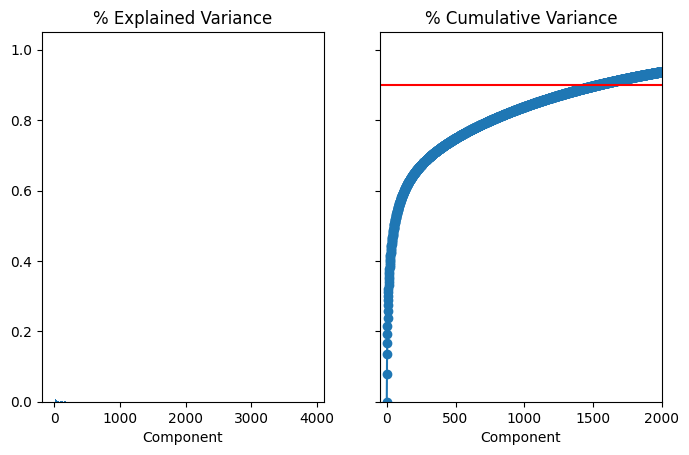

In [14]:
from sklearn.preprocessing import *
from sklearn.decomposition import PCA

def apply_pca(X, transformer = False, components = -1):
    aux = X.copy()
    if transformer:
        X = pd.DataFrame(transformer.fit_transform(X))
        X.columns = aux.columns    
    # Create principal components
    if components == -1:
        pca = PCA()
    else:
        pca = PCA(n_components = components)
        
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2, sharey = True)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance")    # ylim = (0.0, 1.0) o sino sharey en plt.subplots
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance"
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
X_para_pca = train_embeddings
sc = StandardScaler()
X_para_pca = pd.DataFrame(sc.fit_transform(X_para_pca))
pca, X_pca, loadings = apply_pca(X_para_pca)
plt.figure(figsize = (22,5))
ax0, ax1 = plot_variance(pca)
ax1.set_xlim(-50,2000)
ax1.axhline(y = 0.9, color = 'r', linestyle = '-') 

In [15]:
media = np.mean(pca.explained_variance_ratio_)
componentes = []
for i in range(X_pca.shape[1]):
    if pca.explained_variance_ratio_[i] > media: 
        componentes.append(i)

In [16]:
component = 'PC{}'.format(len(componentes))
train_embeddings = X_pca.loc[:,:component]
test_embeddings = sc.transform(test_embeddings)
test_embeddings = pca.transform(test_embeddings)
test_embeddings = pd.DataFrame(test_embeddings, columns = ['PC{}'.format(i) for i in range(1,X_pca.shape[1]+1)]).loc[:,:component]

**Applying regressor**

In [17]:
from sklearn.metrics import mean_absolute_error as mae
def objective(trial):
    # Parámetros XGBoost
    params = {"random_state":trial.suggest_categorical("random_state", [2022]),           # categorical for concrete values
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),   # loguniform for continuos values
        "n_estimators": trial.suggest_int('n_estimators',50,2000),                 # int for discrete values. Interval between [100,2000]
        "max_depth" : trial.suggest_int("max_depth", 1, 20),
        "alpha" : trial.suggest_loguniform('alpha',0.9,1),
        "tree_method": trial.suggest_categorical("tree_method", ['gpu_hist']), 
        "predictor": trial.suggest_categorical("predictor", ["gpu_predictor"])
    }

    model = XGBRegressor(**params)
    X_train_tmp, X_valid_tmp, y_train_tmp, y_valid_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(
        X_train_tmp, y_train_tmp,
        eval_set=[(X_valid_tmp, y_valid_tmp)],
        early_stopping_rounds=35, verbose=0
    )
        
    y_train_pred = model.predict(X_train_tmp)
    y_valid_pred = model.predict(X_valid_tmp)
    train_mae = mae(y_train_tmp, y_train_pred)
    valid_mae = mae(y_valid_tmp, y_valid_pred)
    
    print(f'MCRMSE of Train: {train_mae}')
    print(f'MCRMSE of Validation: {valid_mae}')
    
    return valid_mae

def optuna_xgb(trials = 100, timeout = 1200):
    TRIALS = trials
    TIMEOUT = timeout
    
    sampler = TPESampler(seed=42)

    study = optuna.create_study(
        study_name = 'XGB_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=TRIALS)
    print("Best Score:",study.best_value)
    print("Best trial",study.best_trial.params)
    
    best_params = study.best_params
    return best_params

def objective_lgbm(trial):
    # Parámetros LightGBM
    params = {"random_state":trial.suggest_categorical("random_state", [2022]),           
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 1),   
        "n_estimators": trial.suggest_int('n_estimators',50,2000),                 
        "max_depth" : trial.suggest_int("max_depth", 1, 20),
        "_min_child_weight" : trial.suggest_float("_min_child_weight", 0.1, 10),
        "reg_lambda" : trial.suggest_float("reg_lambda", 0.01, 10),
        "reg_alpha" : trial.suggest_float('reg_alpha',0.01,10),
        "num_leaves" : trial.suggest_int("num_leaves", 50, 100),
        'subsample' : trial.suggest_float('subsample', 0.01, 1), 
        'device': trial.suggest_categorical("device", ['gpu'])
    }

    model = LGBMRegressor(**params)
    X_train_tmp, X_valid_tmp, y_train_tmp, y_valid_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(
        X_train_tmp, y_train_tmp,
        eval_set=[(X_valid_tmp, y_valid_tmp)],
        early_stopping_rounds=35, verbose=0
    )
        
    y_train_pred = model.predict(X_train_tmp)
    y_valid_pred = model.predict(X_valid_tmp)
    train_mae = mae(y_train_tmp, y_train_pred)
    valid_mae = mae(y_valid_tmp, y_valid_pred)
    
    print(f'MCRMSE of Train: {train_mae}')
    print(f'MCRMSE of Validation: {valid_mae}')
    
    return valid_mae

def optuna_lgbm(trials = 100, timeout = 1200):
    TRIALS = trials
    TIMEOUT = timeout
    
    sampler = TPESampler(seed=42)

    study = optuna.create_study(
        study_name = 'LGBM_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective_lgbm, n_trials=TRIALS)
    print("Best Score:",study.best_value)
    print("Best trial",study.best_trial.params)
    
    best_params = study.best_params
    return best_params

In [ ]:
X = train_embeddings
scores = train.select_dtypes([int, float]).columns[:6]
def model_preds(regressor, optuna_tuning):
    '''Returns predictions made by a concrete regressor. '''
    global y
    preds = {}
    for j, col in enumerate(scores): 
        y = train[col]
        best_params = optuna_tuning()
        regressor_tuned = regressor(**best_params)
        
        regressor_tuned.fit(train_embeddings, train[col])  
        preds[j] = regressor_tuned.predict(test_embeddings)

    return preds

xgb_preds = model_preds(XGBRegressor, optuna_xgb)
#lgbm_preds = model_preds(LGBMRegressor, optuna_lgbm)

In [ ]:
#preds = {}
#for i in range(6):
    #preds[i] = (xgb_preds[i] + lgbm_preds[i]) / 2